In [1]:
import sys
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

## imports

In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

In [4]:
import yolov1
from yolov1.config import parse_config

In [5]:
from yolov1.data.dataset import YOLODataset
from yolov1.utils.vis import draw_boxes_pil, draw_boxes_tensor
from yolov1.utils.general import decode_labels

## config

In [6]:
config_path = "../yolov1/src/yolov1/configs/default.yaml"

In [7]:
config = parse_config(config_file=config_path)

config

YOLOConfig(data=DataConfig(root='/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.data', train='valid', val='valid', names=['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck'], augmentations=AugmentationsConfig(horizontal_flip=0.8, vertical_flip=0.0, brightness_contrast=0.8, shift_scale_rotate=0.0, random_crop=0.8, random_crop_dims=(224.0, 224.0))), training=TrainingConfig(batch_size=8, num_workers=4, learning_rate=0.001, epochs=30, checkpoints_dir='/home/ajkdrag/workspace/projects/architectures-impl-pytorch/checkpoints', save_freq=10), inference=InferenceConfig(batch_size=2, checkpoint='/home/ajkdrag/workspace/projects/architectures-impl-pytorch/checkpoints/final_epoch_50.pt', source='/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.data/valid/images'), model=ModelConfig(backbone='resnet18', pretrained=True, backbone_output_channels=512, detector_hidden_sz=1024, input_size=(224, 224), conf_th=0.0, S=7, B=1, nc=5))

## dataset

In [10]:
train_ds = YOLODataset(config, mode="train")

2024-05-07T07:25:40.007712Z [info     ] Loaded 250 samples             func_name=get_data lineno=68


In [11]:
len(train_ds[2])

2

In [12]:
sample = train_ds[4]

In [15]:
sample[0].shape

torch.Size([3, 224, 224])

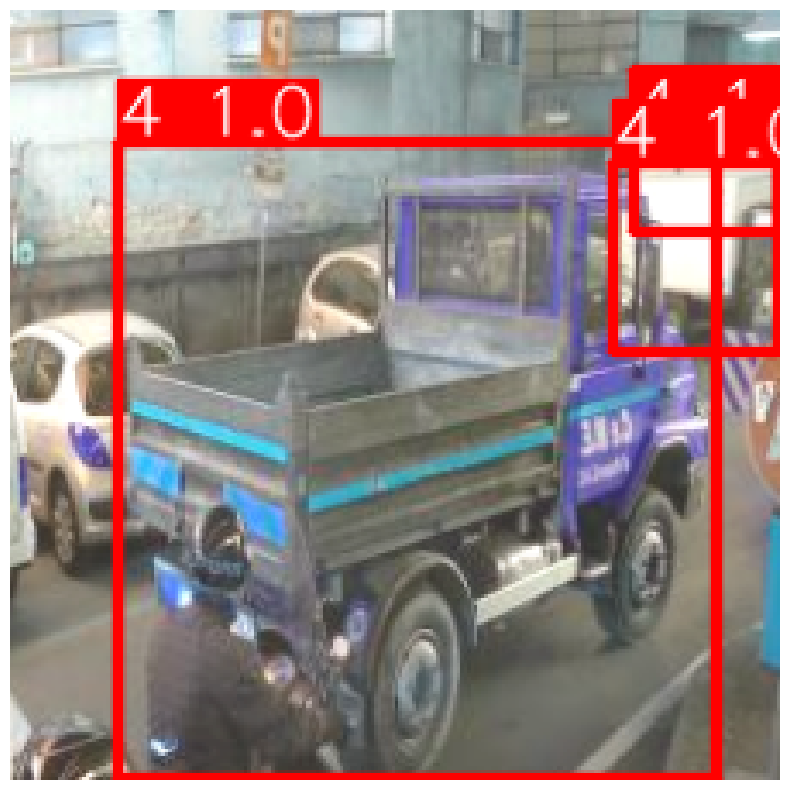

In [16]:
draw_boxes_tensor(
    sample[0],
    decode_labels(sample[1], config.model.S, config.model.B, config.model.nc))

In [17]:
val_ds = YOLODataset(config, mode="val")

2024-05-07T07:27:37.219178Z [info     ] Loaded 250 samples             func_name=get_data lineno=68


## dataloader

In [124]:
train_dataloader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=config.training.batch_size,
        shuffle=True,
        num_workers=config.training.num_workers,
    )
# val_dataloader = torch.utils.data.DataLoader(
#     val_ds,
#     batch_size=config.training.batch_size,
#     shuffle=False,
#     num_workers=config.training.num_workers
# )

Reloading 'yolov1.data.dataset'.


In [131]:
images.dtype

torch.uint8

In [130]:
labels.shape

torch.Size([4, 7, 7, 10])

## arch

In [14]:
# from yolov1.models.arch import YOLOv1

In [15]:
# model = YOLOv1(config.model)

## train

In [10]:
from yolov1.train import main

Reloading 'yolov1.train'.


In [11]:
main(config)

2024-05-07T09:37:30.399386Z [info     ] Loaded 250 samples             func_name=get_data lineno=68
Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-05-07T09:37:31.426713Z [info     ] Loaded model successfully      func_name=main lineno=62
2024-05-07T09:37:53.163391Z [info     ] Epoch [1/30], Train Loss: {'total': 50.05026113986969, 'coord': 45.93284943699837, 'obj': 0.6842409675009549, 'class': 3.180084202438593, 'noobj': 0.2530866345623508} func_name=main lineno=72
2024-05-07T09:38:16.909627Z [info     ] Epoch [2/30], Train Loss: {'total': 10.323798805475235, 'coord': 8.568554855883121, 'obj': 0.2149647434707731, 'class': 1.3608874939382076, 'noobj': 0.17939160927198827} func_name=main lineno=72
2024-05-07T09:38:38.793359Z [info     ] Epoch [3/30], Train Loss: {'total': 4.787977837026119, 'coord': 3.5137006379663944, 'obj

KeyboardInterrupt: 

## infer

In [19]:
from yolov1.detect import main as detect_main
from yolov1.data.dataset import InferenceDataset
from yolov1.data.utils import get_dls_for_inference

In [15]:
config.inference.checkpoint = '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/checkpoints/epoch_21.pt'

In [18]:
model = YOLOv1(config.model)
model.load_state_dict(
    torch.load(config.inference.checkpoint)["model_state_dict"],
)

Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


<All keys matched successfully>

In [20]:
test_dls = get_dls_for_inference(config)

In [31]:
img = next(iter(test_dls))

In [32]:
img.shape

torch.Size([2, 3, 224, 224])

In [33]:
out = model(img)

In [40]:
model.backbone

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [38]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [39]:
total_params  = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Number of parameters: 26193386


In [37]:
total_params  = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")

Number of parameters: 37369898


In [16]:
for res in detect_main(config):
    break

Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-05-07T09:46:45.108333Z [info     ] Model loaded successfully      func_name=main lineno=56


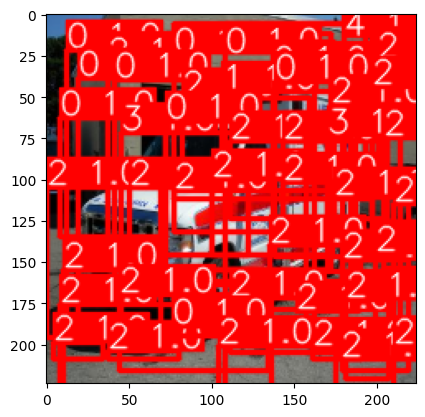

In [17]:
plt.imshow(res["drawn"][0])

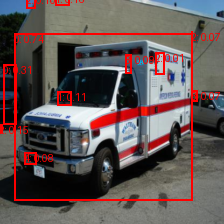

In [15]:
res[0]